<a href="https://colab.research.google.com/github/lfr4704/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/all_modules_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap



# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [7]:
df.shape

(1599, 12)

In [8]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [9]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [10]:
#define target variable
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [11]:
df['quality'].describe()


count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


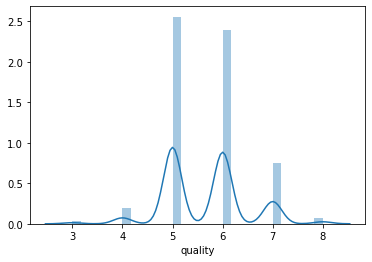

In [12]:
import seaborn as sns
y = df['quality']
sns.distplot(y);

#Convert target to a Classification problem and get baseline metric

In [0]:
df['great'] = df['quality'] >=7

In [14]:
df['great'].value_counts()

False    1382
True      217
Name: great, dtype: int64

In [15]:
#confirm that you are only passing true and false values
y = df['great']
y.unique()

array([False,  True])

In [16]:
#baseline prediction
y.value_counts(normalize=True)

False    0.86429
True     0.13571
Name: great, dtype: float64

In [0]:
#baseline prediction is >70% so accuracy for a metric could be misleading 

In [0]:
df = df.drop(columns='quality')


In [18]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,great
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,False
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,False


In [0]:
#do train_test split
from sklearn.model_selection import train_test_split

In [20]:
train, val = train_test_split(df, train_size=0.80, test_size = .20, stratify=df['great'], random_state=42)
train, test = train_test_split(train, train_size=0.80, test_size=.20,
                              stratify=train['great'], random_state=42)
train.shape, val.shape, test.shape


((1023, 12), (320, 12), (256, 12))

In [0]:
target ='great'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = train[features]
y_test = train[target]

In [22]:
features

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [23]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1296,6.6,0.630,0.00,4.3,0.093,51.0,77.5,0.99558,3.20,0.45,9.5
1295,6.6,0.630,0.00,4.3,0.093,51.0,77.5,0.99558,3.20,0.45,9.5
1096,6.6,0.725,0.09,5.5,0.117,9.0,17.0,0.99655,3.35,0.49,10.8
489,9.3,0.390,0.40,2.6,0.073,10.0,26.0,0.99840,3.34,0.75,10.2
1314,7.0,0.360,0.21,2.4,0.086,24.0,69.0,0.99556,3.40,0.53,10.1


In [0]:

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import category_encoders as ce


In [0]:
#create pipeline
pipeline = make_pipeline(StandardScaler(),
                        DecisionTreeClassifier(max_depth=3))

In [26]:
pipeline.fit(X_train, y_train)
print(f'Val score: {pipeline.score(X_val, y_val)}')

Val score: 0.90625


#Explore other metrics since baseline prediction one sided

In [27]:
#ROC AUC
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred_proba)

0.8275963395180925

In [0]:
# "The ROC curve is created by plotting the true positive rate (TPR) 
# against the false positive rate (FPR) 
# at various threshold settings."

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [29]:
#see the results in a table
pd.DataFrame({'False Positive Rate': fpr,
             'True Positive Rate': tpr,
             'Thresholds': thresholds})

,False Positive Rate,True Positive Rate,Thresholds
0,0.000000,0.000000,1.650000
1,0.010830,0.372093,0.650000
2,0.032491,0.441860,0.411765
3,0.083032,0.627907,0.397059
4,0.086643,0.674419,0.307692
5,0.097473,0.697674,0.266667
6,0.299639,0.767442,0.120930
7,0.328520,0.813953,0.025000
8,1.000000,1.000000,0.019713


Text(0, 0.5, 'True Positive Rate')

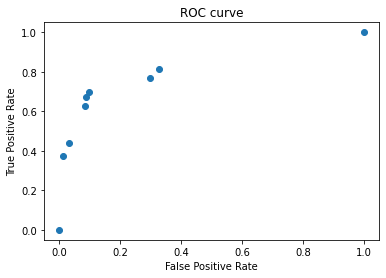

In [30]:
# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [0]:
#Precission and Recall
#recall is also referred as sensitivity


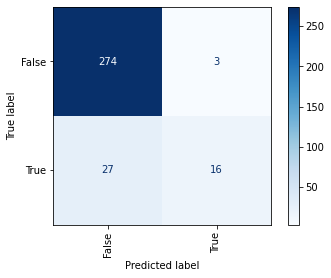

In [32]:
#did not load
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, xticks_rotation='vertical',
                     values_format='.0f', cmap='Blues');

#Create Confusion Matrix Manually

In [33]:
from sklearn.metrics import confusion_matrix
y_pred=pipeline.predict(X_val)
cm = confusion_matrix(y_val, y_pred)
cm

array([[274,   3],
       [ 27,  16]])

In [34]:
normalize_cm = cm/cm.sum(axis=1)[:, np.newaxis]
normalize_cm

array([[0.98916968, 0.01083032],
       [0.62790698, 0.37209302]])

In [35]:
cm.sum(axis=1)[:, np.newaxis].shape

(2, 1)

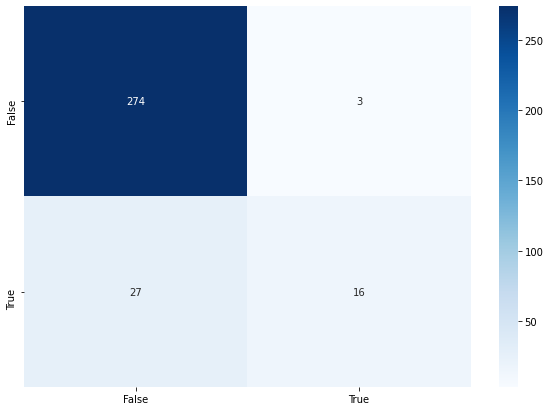

In [36]:
import seaborn as sns
from sklearn.utils.multiclass import unique_labels

cols = unique_labels(y_val)

df_cm = pd.DataFrame(cm, columns=cols, index=cols)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.0f');

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.99      0.95       277
        True       0.84      0.37      0.52        43

    accuracy                           0.91       320
   macro avg       0.88      0.68      0.73       320
weighted avg       0.90      0.91      0.89       320



In [38]:
#precision of positive class
#precision is the ration between allthe positive class vs. actuall positive classes
16/(16+3)

0.8421052631578947

In [39]:
#recall of positive class
#s the number of true positives divided by the number of true positives plus 
#the number of false negatives
16/(16+27)

0.37209302325581395

#Run another model using Random Forest

In [40]:
#Run the pipeline with random forest 
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(StandardScaler(),
                        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
pipeline.fit(X_train, y_train)
print(f'Validation Acc: {pipeline.score(X_val, y_val)}')

Validation Acc: 0.928125


In [41]:
#ROC AUC with random forest
from sklearn.metrics import roc_auc_score
y_pred_proba_rf = pipeline.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred_proba_rf)

0.9271681638821258

In [42]:
from sklearn.metrics import classification_report
y_pred=pipeline.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.93      0.99      0.96       277
        True       0.88      0.53      0.67        43

    accuracy                           0.93       320
   macro avg       0.91      0.76      0.81       320
weighted avg       0.93      0.93      0.92       320



#Feature importances

In [43]:
X_train.dtypes


fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
dtype: object

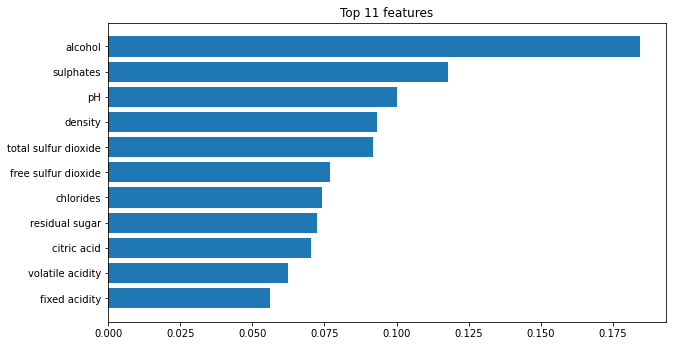

In [44]:

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

#plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n=11


plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
#importances.sort_values()[-n].plot.barh(color='grey');
y_pos = importances.index.tolist()
x_pos = importances.sort_values()
chart = plt.barh(y_pos, x_pos)
#chart.set_yticks(y_pos)
#chart.set_yticklabels(importances)

In [45]:
importances.sort_values(ascending=False)


alcohol                 0.184213
sulphates               0.117951
volatile acidity        0.100264
density                 0.093317
citric acid             0.091898
chlorides               0.077013
fixed acidity           0.074225
total sulfur dioxide    0.072273
residual sugar          0.070404
pH                      0.062478
free sulfur dioxide     0.055964
dtype: float64

In [46]:
#use eli5 library
transformers = make_pipeline(StandardScaler())

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [48]:
!pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [49]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model,
                                scoring='accuracy',
                                n_iter=5,
                                random_state=42)

permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [50]:
feature_names = X_val.columns.to_list()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=True)

pH                     -0.002500
residual sugar         -0.000625
fixed acidity           0.000625
chlorides               0.003125
free sulfur dioxide     0.006250
density                 0.009375
citric acid             0.013125
total sulfur dioxide    0.013750
volatile acidity        0.023750
sulphates               0.041250
alcohol                 0.055000
dtype: float64

In [51]:
eli5.show_weights(permuter,
                 top=None,
                 feature_names=feature_names)

Weight,Feature
0.0550 ± 0.0184,alcohol
0.0412 ± 0.0170,sulphates
0.0237 ± 0.0170,volatile acidity
0.0137 ± 0.0050,total sulfur dioxide
0.0131 ± 0.0073,citric acid
0.0094 ± 0.0125,density
0.0062 ± 0.0112,free sulfur dioxide
0.0031 ± 0.0079,chlorides
0.0006 ± 0.0061,fixed acidity
-0.0006 ± 0.0061,residual sugar


#XGBoost

In [52]:
from xgboost import XGBClassifier

pipeline=make_pipeline(StandardScaler(),
                      XGBClassifier(n_estimator=100, random_state=42, n_jobs=-1))

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimator=100, n_estimators=100, n_jobs=-1,
                               nthread=None, objective='binary:logistic',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, seed=None, silent=None,
                               subsample=1, verbosity=1))],
         verbose=False)

In [53]:
from sklearn.metrics import accuracy_score

y_pred=pipeline.predict(X_val)
print(f'Val Acc: {accuracy_score(y_val, y_pred)}')

Val Acc: 0.909375


In [62]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_val_scaler = scaler.transform(X_val)

model = XGBClassifier(n_estimator=100,
                     max_depth=3,
                     learning_rate=0.5,
                     n_jobs=-1)

eval_set=[(X_train_scaler, y_train), (X_val_scaler, y_val)]

model.fit(X_train_scaler, y_train,
         eval_set=eval_set,
         eval_metric='error',
         early_stopping_rounds=30)

[0]	validation_0-error:0.106549	validation_1-error:0.09375
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.106549	validation_1-error:0.1
[2]	validation_0-error:0.103617	validation_1-error:0.09375
[3]	validation_0-error:0.098729	validation_1-error:0.09375
[4]	validation_0-error:0.099707	validation_1-error:0.096875
[5]	validation_0-error:0.090909	validation_1-error:0.096875
[6]	validation_0-error:0.086022	validation_1-error:0.090625
[7]	validation_0-error:0.086999	validation_1-error:0.0875
[8]	validation_0-error:0.087977	validation_1-error:0.090625
[9]	validation_0-error:0.084066	validation_1-error:0.090625
[10]	validation_0-error:0.081134	validation_1-error:0.09375
[11]	validation_0-error:0.068426	validation_1-error:0.096875
[12]	validation_0-error:0.071359	validation_1-error:0.09375
[13]	validation_0-error:0.065494	validation_1-error:0.084375
[14]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimator=100,
              n_estimators=100, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

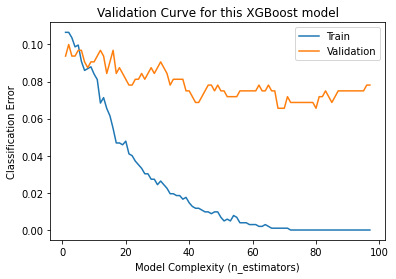

In [64]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
#plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();

#Visualize and interpret partial dependence plots

### One Feature

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'alcohol'

isolated = pdp_isolate(model=pipeline,
                       dataset=X_val,
                       model_features=X_val.columns,
                       feature=feature
    
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


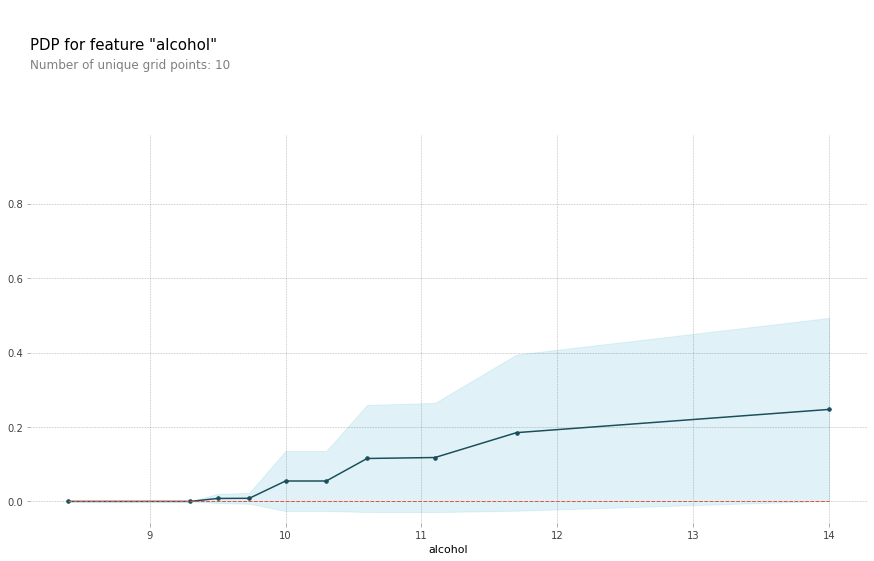

In [76]:
pdp_plot(isolated, feature_name=feature);

#Two features